<h1> Implementationen und Tests <h1>

Der erste Schritt der im Projekt implementiert wurde, ist die Leistungszahl (engl. figure of merit), die zu einem gegebenen Generatorvektor (engl. generating vector) einen Wert zurück gibt. Dieser sagt aus, wie gut besagter Vektor für die Erstellung eines Gitters geeignet ist. Hierbei sind geringere Werte besser. <br>
Im ersten Schritt wurden dafür die nötigen Pakete in Python implementiert und übersichtshalber die ersten kleinen Methoden definiert. <br>
<br>
c(n) definiert die Menge: $ C(N):= (-N/2,N/2] \cap \mathbb{Z}$ <br>
<br>
r1(h): Für $h \in \mathbb{Z}$ ist $r_1(h):=max(1,|h|)$


In [1]:
import numpy as np
import math
import time

def c(n):
    return np.array(range(int(-n/2),int(n/2+1)))

def r1(h):
    return max(1,abs(h))

<br>
Die eigentliche Leistungszahl ist nun folgendermaßen definiert: <br>
$$\begin{aligned} R_N(g)=-1 + \frac{1}{N} \sum \limits_{n=0}^{N-1} \prod \limits_{j=1}^s \phi(\frac{ng_j}{N}) \end{aligned}$$ 
mit
$$\begin{aligned} \phi(x)=\sum \limits_{h\in C(N)} \frac{1}{r_1(h)}exp(2\pi ihx) \end{aligned}$$
Zuerst wird $\phi (x)$ implementiert.

In [2]:
def phi(x,n):   
    result = 0
    for h in c(n):
        result = result + ((1/r1(h))*np.exp(2*math.pi*complex(0,1)*h*x))
    return result

<br>
Wenn wir jetzt jedoch ohne Weiteres $R_N(g)$ implementieren befinden wir uns bei einer Laufzeit im Bereich von $O(N^2)$. <br>
Da $\phi (ng/N)$ allerdings nur maximal $N$ verschiedene Werte annimmt - nämlich $\phi (ng/N)=\phi (k/N)$ für $k \in {0,1,...,N-1}$ - können wir die möglichen Werte schon im Voraus berechnen und in einem Array speichern. Statt $\phi (ng/N)$ zu berechnen können wir einfach den Eintrag an der Stelle $n  g (mod (N))$ aus dem Array nehmen.
Damit kommen wir in einen Bereich von $O(sN)$. <br>
<br>
Also erstellen wir zu erst eine Methode, die uns die Werte im vorraus berechnet und in ein Array schreibt, und im Anschluss die Berechnung der Leistungszahl mit Hilfe der Werte.

In [3]:
def precom(n): 
    precomvalues = [0]*n
    for i in range(0,n):
        precomvalues[i] = phi(i/n,n)
    return precomvalues

In [4]:
def fom_precom(g,n):
    result = 0
    precomvalues = precom(n)
    for i in np.array(range(0,n)):
        helper = 1 
        for x in g:
            helper = helper * precomvalues[(i*x)%n]
        result = result + helper
    merit =  result/n-1
    if merit.imag < 1e-14:
        return merit.real
    return "Error, figure of merit has a complex part"

In [5]:
def fom_precom_time(g,n): 
    start = time.process_time()
    fom = fom_precom(g,n)
    end = time.process_time()
    cputime = end - start
    print(fom,"   time: ", format(cputime))

<br>
Hierbei sei angemerkt, dass die Leistungszahl einen Imaginärteil mit sich führt, der aber fast immer in einem Bereich <1e-15 liegt, sodass er vernachlässigt werden kann. <br> <br>
Nun können wir dies an dem, vom Latnetbuilder erstellten, Generatorvektor $[1, 282, 197, 377, 233, 55, 73, 263, 408, 46]$ testen.

In [6]:
fom_precom_time([1, 282, 197, 377, 233, 55, 73, 263, 408, 46],1009)

436619963.19030744    time:  11.359375


<br>
Und auch der Generatorvektor aus der Matlab Implementation $[1,390,265,180,242,491,450,347,77,332]$ liefert einen ähnlichen Wert:

In [7]:
fom_precom_time([1, 390, 265, 180, 242, 491, 450, 347, 77, 332],1009)

436619963.311887    time:  10.96875


<br>
Allerdings wissen wir zur Zeit noch gar nicht, ob dies überhaupt ein passender Wert für die Leistungszahl ist. <br>
Aus dem Grund berechnen wir im nächsten Schritt den maximalen Wert, den die Leistungszahl überhaupt annehmen kann. Es gilt: <br>
$$\begin{aligned} R_N(g) \leq \frac{2^{s+1}(log N +1)^s}{N} \end{aligned}$$

In [8]:
def estimatemax(s,n):
   return 2**(s+1)*(math.log(n)+1)**s/n
estimatemax(10,1009)

1962858099.5554516

<h2> Implementation des Algorithmus <h2>

Der eigentliche Algorithmus funktioniert nun so, dass jede Komponente $g_j$ aus $g$ so gewählt wird, dass $R_N(g)$ minimiert wird. <br>
Um die Laufzeit von momentan $O(s^2 N^2)$ weiter zu senken können wir nach jedem Schritt des CBC Algorithmus die Werte $\prod_{j=1}^d \phi(\frac{ng_j}{N})$ für alle 
$n \in {0,1,...,N-1}$ speichern. Dadurch braucht die Berechnung der Werte $\prod_{j=1}^{d+1} \phi(\frac{ng_j}{N})$ nur noch $N$ Multiplikationen für jeden Wert von $g_{d+1}$, womit wir auf eine Schrittzahl von $O(N^2)$ zur Berechnung der nächsten Komponente kommen. <br>
Um von $\prod_{j=1}^d \phi(\frac{ng_j}{N})$ auf $\prod_{j=1}^{d+1} \phi(\frac{ng_j}{N})$ zu kommen benötigen wir ebenfalls nur $N$ Operationen, sodass wir insgesamt bei einer Laufzeit von $O(sN^2)$ sind.<br>
<br>
Erinnern wir uns zurück an die Werte der $\phi$ Funktion, die wir im Vorraus berechnen wollen.
$$\begin{aligned} \phi_N=(\phi(\frac{0}{N}),\phi(\frac{1}{N}),...,\phi(\frac{N-1}{N}))^T \end{aligned}$$
So lässt sich auch die beschleunigen, in dem Wir eine schnelle Fourier Transformation durchführen, sodass wir hier auf Kosten von $O(N logN)$ kommen:
$$\begin{aligned} \phi_N = \sqrt{N} F_N x \end{aligned}$$
$$\begin{aligned} x = (r_1(0)^{-1},...,r_1(\frac{N-1}{2})^{-1},r_1(\frac{N-1}{2})^{-1},...,r_1(1)^{-1})^T \end{aligned}$$
In Python geht das ganz einfach mit Hilfe der Numpy Methode numpyp.fft.fft.
Angenommen wir haben bereits die ersten Werte des Generatorvektors berechnet und suchen nun die nächste Komponente z. Mit $\eta_{d-1} = \prod_{j=1}^{d-1} \phi(\frac{ng_j}{N})$ können wir $R_N(g)$ nun folgendermaßen darstellen:
$$\begin{aligned} R_N(z)= -1 + \frac{\phi(0)^d}{N} + \frac{1}{N} \sum \limits_{n=1}^{N-1} \phi(\frac{nz}{N}) \eta_{d-1}(n) \end{aligned}$$
Demnach können wir statt $R_N(z)$ einfach
$$\begin{aligned} T_N(z) = \sum \limits_{n=1}^{N-1} \phi(\frac{nz}{N})\eta_{d-1}(n) \end{aligned}$$
minimieren. Mit dem Vektor $\eta_{d-1} = (\eta_{d-1}(1),...,\eta_{d-1}(N-1))^T$ lässt sich $T_N$ darstellen als:
$$\begin{aligned} T_N = \Omega_N \eta_{d-1},\text{ mit } \Omega_N := (\phi(\frac{nz}{N}))_{1\leq z,n \leq N-1} \end{aligned}$$ 

Die Matrix können wir schon einmal betrachten:

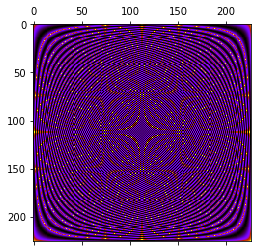

In [9]:
from test import tools
from figure import plot_figure
plot_figure(tools.omega_matrix(227))

Da die normale Multiplikation von Matrix und Vektor zu langsam ist, wollen wir auch dies mit Hilfe von der schnellen Fourier Transformation beschleunigen. Dazu benutzen eine Eigenschaft der Matrix $\Omega_N$. Diese kann nämlich folgendermaßen dargestellt werden:
$$\begin{aligned} \Omega_N = \Pi(q)^T \overline{F}_{N-1} D F_{N-1} \Pi(q^{-1})^T \end{aligned}$$
Hierbei bezeichnet q die Primitivwurzel mod N und \begin{aligned} 
\pi_{k,l}(q) = 
\begin{cases}
1 & \text{für } k \equiv q^l (mod \text{ } N)\\
0& \text{sonst}  
\end{cases}
\end{aligned}
Damit kommen wir auf eine Insgesamte Laufzeit des Algorithmus von $O(N logN)$. 
Es folgt mein erster Versuch der Implementierung, der offensichtlicher Weise noch absolut nicht optimiert ist:

In [10]:
from test import generatorp as gp

def fastcbc(n,s):   #algorithm 4.8 with FFT
    generating_vector = [1]*s
    omega_n = tools.omega_matrix_c(n)
    phi_n = tools.getphi_n(n)  #1 
    q = gp.generatorp(n)
    diagvec = tools.getdiagmatrixasvector(q,n,phi_n)
    permmat = tools.getpermmatrix(q,n)
    permmatinv = tools.getpermmatrix(gp.pinverse(q,n),n)
    eta_vector = [1]*(n-1)   #2
    #3:
    for d in range(1,s):
        first = np.matmul(np.transpose(permmatinv),eta_vector)
        second = np.fft.fft(first)
        third = np.multiply(diagvec,second)
        fourth = np.fft.ifft(third)
        T_n = np.matmul(np.transpose(permmat),fourth)      #i)
        generating_vector[d-1] = np.argmin(T_n)+1 #ii)
        for i in range(0,n-1):                   #iii)
            eta_vector[i] = eta_vector[i] * phi_n[(i*generating_vector[d-1])%n] 
    return generating_vector

fastcbc(1009,10)

[16, 973, 366, 3, 348, 575, 680, 680, 926, 1]

Und auch von unserm Vektor können wir die Leistungszahl bestimmen:

In [11]:
fom_precom_time([16, 973, 366, 3, 348, 575, 680, 680, 926, 1],1009)

436619979.9379748    time:  11.453125
